# Team A
Participants:
- Axel Romanelli romanelli.1945758@studenti.uniroma1.it
- Viktoriia Vlasenko vlasenko.2088928@studenti.uniroma1.it

## 1. Extract structured information from the HTML pages (e.g., title, author, genres, ratings, reviews).
Parse pages
We provide a ZIP archive containing all the HTML pages for the books included in this challenge. You can download the dataset from the Data section. Once extracted, you will have access to the full set of raw Goodreads pages. Your next step is to parse these documents and extract structured information about each book.

### Install packages

In [173]:
!pip3 install bs4
!pip3 install matplotlib
!pip3 install seaborn

69865.81s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable


69871.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable


69877.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable


In [61]:
# for parsing
from bs4 import BeautifulSoup
import os
import re
import json
import html
import json

# for progress tracing
from tqdm import tqdm

### Extract data from the HTML tags
As the structure we decided to extract the following information about the books that may help us to clusterize them by genre.
```json
{
  "id": 0,
  "author": "Markus Zusak",
  "title": "The Book Thief",
  "description": "An alternate cover edition can be found hereIt is 1939. Nazi Germany. The country is holding its breath. Death has never been busier, and will be busier still. By her brother's graveside, Liesel's life is changed when she picks up a single object, partially hidden in the snow. It is The Gravedigger's Handbook, left behind there by accident, and it is her first act of book thievery. So begins a love affair with books and words, as Liesel, with the help of her accordian-playing foster father, learns to read. Soon she is stealing books from Nazi book-burnings, the mayor's wife's library, wherever there are books to be found. But these are dangerous times. When Liesel's foster family hides a Jew in their basement, Liesel's world is both opened up, and closed down. In superbly crafted writing that burns with intensity, award-winning author Markus Zusak has given us one of the most enduring stories of our time.",
  "language": "English",
  "awards": [],
  "reviews": []
}
```


In [76]:
sample_html = "/Users/viktoriiavlasenko/Downloads/Магістратура/Big Data Computing/00000000.html"

In [56]:
def get_soup(html_file_path):
    with open(html_file_path, 'r', encoding='utf-8') as f:
        html_content = f.read()

    return BeautifulSoup(html_content, 'html.parser') 

In [57]:
soup = get_soup(sample_html)

#### Extract ID

In [111]:
def extract_id(html_file_path):
    filename = os.path.basename(html_file_path)
    name, ext = os.path.splitext(filename)

    if ext.lower() != ".html":
        raise ValueError(f"Expected .html file, got {filename}")

    return int(name)

In [112]:
extract_id(sample_html)

0

#### Extract Author

In [82]:
# ---------- helper ----------
def clean_text(text):
    if not text:
        return None
    return re.sub(r'\s+', ' ', text).strip()

In [85]:
def extract_author(soup):
    author = None
    author_tag = soup.find("a", class_="ContributorLink")
    if author_tag:
        author = clean_text(author_tag.get_text())
    return author

In [86]:
extract_author(soup)

'Markus Zusak'

#### Extract Title

In [109]:
def extract_title(soup):
    # 1. Preferred: data-testid
    title_tag = soup.find("h1", {"data-testid": "bookTitle"})
    if title_tag and title_tag.get_text(strip=True):
        return title_tag.get_text(strip=True)

    # 2. Fallback: h1 with title-like class
    title_tag = soup.find("h1", class_="Text__title1")
    if title_tag and title_tag.get_text(strip=True):
        return title_tag.get_text(strip=True)

    # 3. Last resort: first h1 on page
    title_tag = soup.find("h1")
    if title_tag and title_tag.get_text(strip=True):
        return title_tag.get_text(strip=True)

    return None

In [110]:
extract_title(soup)

'The Book Thief'

#### Extract Description
Sometimes in the description there are notes that are not related to the actual book's description.

In [ ]:
def clean_description(text):
    if not text:
        return None

    # Normalize whitespace early
    text = re.sub(r"\s+", " ", text).strip()

    # Remove Librarian's note (even if inline, no punctuation, with links)
    text = re.sub(
        r"librarian['’]s note:\s*.*?(?=(it is\s+\d{4}|[A-Z][a-z]))",
        "",
        text,
        flags=re.IGNORECASE
    )

    # Remove parenthetical Note blocks completely
    text = re.sub(
        r"\(\s*note:.*?\)",
        "",
        text,
        flags=re.IGNORECASE
    )

    # Fix missing space after punctuation (HTML artifact)
    text = re.sub(r"([.!?])([A-Z])", r"\1 \2", text)

    # Final cleanup
    text = text.strip(" :-–")

    return text.strip()

In [121]:
def extract_description(soup):
    desc_container = soup.find("div", {"data-testid": "description"})
    if desc_container:
        formatted = desc_container.find("span", class_="Formatted")
        if formatted:
            return clean_description(clean_text(formatted.get_text()))
    return None

Messy, but ok

In [125]:
extract_description(soup)

"An alternate cover edition can be found hereIt is 1939. Nazi Germany. The country is holding its breath. Death has never been busier, and will be busier still. By her brother's graveside, Liesel's life is changed when she picks up a single object, partially hidden in the snow. It is The Gravedigger's Handbook, left behind there by accident, and it is her first act of book thievery. So begins a love affair with books and words, as Liesel, with the help of her accordian-playing foster father, learns to read. Soon she is stealing books from Nazi book-burnings, the mayor's wife's library, wherever there are books to be found. But these are dangerous times. When Liesel's foster family hides a Jew in their basement, Liesel's world is both opened up, and closed down. In superbly crafted writing that burns with intensity, award-winning author Markus Zusak has given us one of the most enduring stories of our time."

#### Extract Language
Even if a book in English, the reviews may be in another languages. We will try to manage it on the data cleaning step.

In [127]:
def extract_language(soup):
    for item in soup.find_all("div", class_="DescListItem"):
        dt = item.find("dt")
        if dt and dt.get_text(strip=True).lower() == "language":
            dd = item.find("dd")
            if not dd:
                return None

            value_div = dd.find("div", {"data-testid": "contentContainer"})
            if value_div:
                return value_div.get_text(strip=True)

            # Fallback: any text inside <dd>
            return dd.get_text(strip=True)

    return None

In [128]:
extract_language(soup)

'English'

#### Extract Awards
In the following steps we will proceed with one-hot encoding to make a new feature from the awards. We think that can improve clustering.

In [1]:
def normalize_awards(raw_awards):
    normalized = []

    if not raw_awards:
        return normalized

    # If it's already a list, join first
    if isinstance(raw_awards, list):
        raw_text = " ".join(raw_awards)
    else:
        raw_text = raw_awards

    # Decode HTML entities (&apos; → ')
    raw_text = html.unescape(raw_text)

    # Split on commas
    parts = raw_text.split(",")

    for part in parts:
        clean = part.strip()
        if clean:
            normalized.append(clean)

    # Deduplicate while preserving order
    normalized = list(dict.fromkeys(normalized))

    return normalized

In [78]:
def extract_awards(soup):
    awards = []

    for script in soup.find_all("script", type="application/ld+json"):
        try:
            data = json.loads(script.string)
        except Exception:
            continue

        if isinstance(data, dict) and "awards" in data:
            if isinstance(data["awards"], list):
                awards.extend(data["awards"])
            elif isinstance(data["awards"], str):
                awards.append(data["awards"])

    # clean & deduplicate
    awards = list(dict.fromkeys(a.strip() for a in awards if a.strip()))
    return normalize_awards(awards)

In [69]:
extract_awards(soup)

['National Jewish Book Award Children’s and Young Adult Literature (2006)',
 "Book Sense Book of the Year Award Children's Literature (2007)",
 'Buxtehuder Bulle (2008)',
 'Sydney Taylor Book Award Teen Readers (2007)',
 'Prijs van de Kinder- en Jeugdjury Vlaanderen (2009)',
 'Michael L. Printz Award (2007)',
 'Exclusive Books Boeke Prize (2007)',
 'Rhode Island Teen Book Award (2008)',
 'The Quill Award Young Adult/Teen (2006)',
 'Zilveren Zoen (2008)',
 'Teen Read Award Best All-Time-Fave (2010)',
 'Deutscher Jugendliteraturpreis Preis der Jugendjury (2009)',
 'Association of Jewish Libraries Teen Book Award (2006)',
 'Lincoln Award (2010)',
 'Australian Book Industry Award (ABIA) Literary Fiction (2008)',
 'Kathleen Mitchell Award',
 'Ena Noel Award (2008)',
 'Literaturpreis der Jury der jungen Leser Jugendbuch (2009)',
 'LovelyBooks Leserpreis Allgemeine Literatur (2009)',
 'Margaret A. Edwards Award (2014)']

In [70]:
len(extract_awards(soup))

20

#### Extract Reviews
We noticed that in the class tag with reviews we are extracting also book description and author's bio. In the function `extract_all_reviews` we excluded these sections to keep data stuctured and separated for the further analysis.

In [104]:
def extract_all_reviews(soup):
    reviews = []

    # Exclude book description
    description_div = soup.find("div", {"data-testid": "description"})

    # "About the author" section
    author_page_section = None
    for section in soup.find_all("div", class_="PageSection"):
        title = section.find("h3")
        if title and title.get_text(strip=True).lower() == "about the author":
            author_page_section = section
            break


    # collect all formatted spans
    formatted_spans = soup.find_all("span", class_="Formatted")

    for span in formatted_spans:
        # Exclude book description
        if description_div and description_div in span.parents:
            continue

        # Exclude author bio
        if author_page_section and author_page_section in span.parents:
            continue

        text = span.get_text(" ", strip=True)

        reviews.append(text)

    return reviews

In [105]:
for id, review in enumerate(extract_all_reviews(soup)):
    print("---REVIEW {}---".format(id))
    print(review)
    print()

---REVIEW 0---
Just to clarify: Yes, I did cry. I've read a lot of positive and negative reviews for this book. I can see why people wouldn't like it - I really can. Perhaps because I took a lot out of it personally, I found I enjoyed it a lot. Quick test to see if you'll like this book: 1. Did you like Anne of Green Gables? 2. Can you cope with an off-beat, melancholy, caustic, dead-pan, self-righteous narrator? 3. Do you like words? (Questions 4-8 were all about what kind of underwear you're wearing so don't worry about them). So, let's all gather around for story time with Mistress Kat. Two incidents set me off lately. 1.	My neighbour came to me and complained about the Islanders (for those not Australian: the Tongan, Fiji, Papa New Guinea and New Zealand populations of Australia) causing trouble and otherwise defiling our great and beautiful nation. 2.	I was tooling around on Facebook when I noticed one of my friends (one of those friends you’ve never met except in an internet comm

### Extract Book Info
Final version of the function `extract_book_data` that parses the book's information from html file.

In [2]:
def extract_book_data(html_file_path):
    with open(html_file_path, 'r', encoding='utf-8') as f:
        html_content = f.read()

    soup = BeautifulSoup(html_content, 'html.parser')

    book_data = {
        "id": extract_id(html_file_path),
        "author": extract_author(soup),
        "title": extract_title(soup),
        "description": extract_description(soup),
        "language": extract_language(soup),
        "awards": extract_awards(soup),
        "reviews": extract_all_reviews(soup),
    }

    return book_data

### Sample extraction testing
Run few samples to see if everything is ok.

In [131]:
extract_book_data(sample_html)

{'id': 0,
 'author': 'Markus Zusak',
 'title': 'The Book Thief',
 'description': "An alternate cover edition can be found hereIt is 1939. Nazi Germany. The country is holding its breath. Death has never been busier, and will be busier still. By her brother's graveside, Liesel's life is changed when she picks up a single object, partially hidden in the snow. It is The Gravedigger's Handbook, left behind there by accident, and it is her first act of book thievery. So begins a love affair with books and words, as Liesel, with the help of her accordian-playing foster father, learns to read. Soon she is stealing books from Nazi book-burnings, the mayor's wife's library, wherever there are books to be found. But these are dangerous times. When Liesel's foster family hides a Jew in their basement, Liesel's world is both opened up, and closed down. In superbly crafted writing that burns with intensity, award-winning author Markus Zusak has given us one of the most enduring stories of our time.

In [132]:
sample_html = "/Users/viktoriiavlasenko/Downloads/Магістратура/Big Data Computing/00000001.html"
extract_book_data(sample_html)

{'id': 1,
 'author': 'Stephenie Meyer',
 'title': 'Twilight',
 'description': "About three things I was absolutely positive. First, Edward was a vampire. Second, there was a part of him - and I didn't know how dominant that part might be - that thirsted for my blood. And third, I was unconditionally and irrevocably in love with him. Deeply seductive and extraordinarily suspenseful, Twilight is a love story with bite.",
 'language': 'English',
 'awards': ['Georgia Peach Book Award (2007)',
  'Buxtehuder Bulle (2006)',
  'Kentucky Bluegrass Award 9-12 (2007)',
  'Prijs van de Kinder- en Jeugdjury Vlaanderen (2008)',
  'Books I Loved Best Yearly (BILBY) Awards Older Readers (2009)',
  "West Australian Young Readers' Book Award (WAYRBA) Older Readers (2008)",
  'Garden State Book Award Fiction (Grades 9-12) (2008)',
  'South Carolina Book Award Young Adult Book Award (2008)',
  'Grand Canyon Reader Award Teen Book (2008)',
  'Maryland Black-Eyed Susan Book Award High School (2008)',
  'Gol

### Construct Dataset
Parsed dataset will be saved into `jsonl` file format.

In [3]:
ROOT_FOLDER = "/Users/viktoriiavlasenko/Downloads/Магістратура/Big Data Computing/pages"

In [155]:
books_path = ROOT_FOLDER
file_paths = []

for html_file in os.listdir(books_path):
    file_path = os.path.join(books_path, html_file)
    if os.path.isfile(file_path):
        file_paths.append(file_path)

print(len(file_paths))

1934


Confirm if we collected our file pathes correctly: $1934 === 1934$.

In [156]:
len(file_paths)

1934

### Parse Books
Main run

In [164]:
def write_book_data_to_jsonl(output_file_path, file_paths):
    processed_files = set()
    skipped_files = set()

    with open(output_file_path, "w", encoding="utf-8") as f_jsonl:
        for file_path in file_paths:
            # Skip duplicates
            if file_path in processed_files:
                continue

            book_data = extract_book_data(file_path)
            if not book_data:
                print(f"{file_path} was not parsed correctly")
                skipped_files.add(file_path)
                continue

            processed_files.add(file_path)

            # Skip completely empty records
            if all(v in [None, "", [], "none"] for v in book_data.values()):
                skipped_files.add(file_path)
                print(f"All values undefined, skipping: {file_path}")
                continue

            # Write one JSON object per line
            json.dump(book_data, f_jsonl, ensure_ascii=False)
            f_jsonl.write("\n")

    print(f"Processed files: {len(processed_files)}")
    print(f"Skipped files: {len(skipped_files)}")

#### Write data in the file

In [166]:
JSON_FILENAME = "books.jsonl"

In [167]:
write_book_data_to_jsonl(
    output_file_path=JSON_FILENAME,
    file_paths=tqdm(file_paths, desc="Processing files", unit="file")
)

Processing files: 100%|██████████| 1934/1934 [10:37<00:00,  3.03file/s]

Processed files: 1934
Skipped files: 0


## 2. Process and clean the data, combining both structured features and text fields through basic NLP techniques.
At this point, you should have constructed your dataset. It is now time to preprocess it. You are free to choose how to represent your data: you may vectorize rows as you prefer, discard irrelevant features, or perform additional feature engineering. The only limit is your creativity.

A substantial portion of the preprocessing will involve handling textual data. We suggest to you, at minimum, to:

- Removing stopwords
- Removing punctuation
- Stemming
Anything else you think it's needed

For this purpose, you can use the nltk library https://www.nltk.org.

### Install packages

In [48]:
# for EDA and data cleaning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from collections import Counter

### Loading the data into the data frame

In [49]:
JSON_FILENAME = "books.jsonl"
books = pd.read_json(JSON_FILENAME, lines=True)
books.head()

,id,author,title,description,language,awards,reviews
0,1697,Jude Deveraux,The Summerhouse,Have you ever wanted to rewrite your past? Thr...,English,[],"[So ""The Summerhouse"" series by Jude Deveraux ..."
1,985,Charlaine Harris,A Touch of Dead,Meet Sookie Stackhouse! Sookie Stackhouse is e...,English,[],[(B+) 76% | Good Notes: Kind of like finding a...
2,86,William Shakespeare,Macbeth,"One night on the heath, the brave and respecte...",English,[],"[Ladies and gentlemen, may I present A Thing Y..."
3,439,Steven Pressfield,Gates of Fire,"At Thermopylae, a rocky mountain pass in north...",English,[],[One of the two best standalone books that I’v...
4,593,Morgan Rhodes,Falling Kingdoms,"In the three kingdoms of Mytica, magic has lon...",English,[],[Falling Kingdoms crushed my heart but exceede...


### Data Cleaning

#### Basic information about the dataset

In [50]:
print("Number of rows:", books.shape[0])
print("Number of columns:", books.shape[1])
print("Columns:")
print(books.columns)
print("Data Types:")
print(books.dtypes)

Number of rows: 1934
Number of columns: 7
Columns:
Index(['id', 'author', 'title', 'description', 'language', 'awards',
       'reviews'],
      dtype='object')
Data Types:
id              int64
author         object
title          object
description    object
language       object
awards         object
reviews        object
dtype: object


#### Missing Values
Good job in parsing, no missing values.

In [51]:
books.isna().sum()

id             0
author         0
title          0
description    0
language       0
awards         0
reviews        0
dtype: int64

But how about missing `awards` or `reviews` for the books. These features can be empty lists.

In [52]:
books["awards"].head(10)

0                                                   []
1                                                   []
2                                                   []
3                                                   []
4                                                   []
5                                                   []
6    [Aspen Gold Readers Choice Award Contemporary ...
7    [Davitt Award Best Young Adult (2020), Goodrea...
8    [Goodreads Choice Award History & Biography (2...
9                                                   []
Name: awards, dtype: object

In [53]:
books["reviews"].head(10)

0    [So "The Summerhouse" series by Jude Deveraux ...
1    [(B+) 76% | Good Notes: Kind of like finding a...
2    [Ladies and gentlemen, may I present A Thing Y...
3    [One of the two best standalone books that I’v...
4    [Falling Kingdoms crushed my heart but exceede...
5    [Dear John by Nicholas Sparks is one of those ...
6    [“Every woman treats me that way, Reese. I’m n...
7    [Four Dead Queens was being given away when I ...
8    [Erik Larson is my favorite author of nonficti...
9    [I think I now understand better why so many L...
Name: reviews, dtype: object

As we can see **1112** out of **1934** books don't have any `awards`. And only **3** books don't have any `reviews`.

In [54]:
empty_awards = (books["awards"].apply(lambda x: isinstance(x, list) and len(x) == 0)).sum()
empty_reviews = (books["reviews"].apply(lambda x: isinstance(x, list) and len(x) == 0)).sum()

print(empty_awards, empty_reviews)

1112 3


### Data visualization

#### Linguistical plotting

**1.  Verify language of the books.**

All books are in English.

language
English    1934
Name: count, dtype: int64


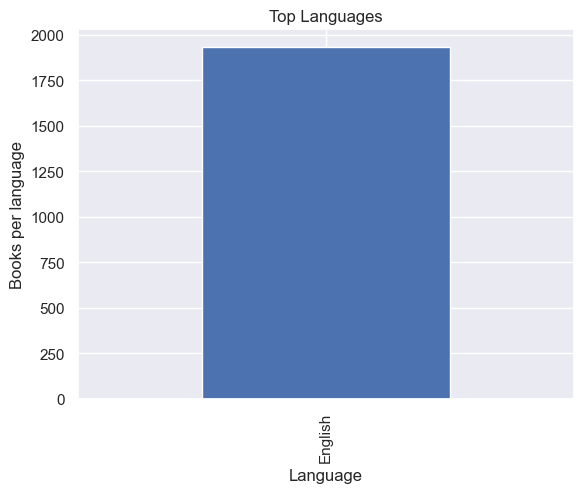

In [55]:
language_counts = books["language"].value_counts().sort_values(ascending=False)

# Print the top 10 languages
print(language_counts.head(10))

language_counts.head(10).plot(kind='bar')
plt.title('Top Languages')
plt.xlabel('Language')
plt.ylabel('Books per language')
plt.show()

#### Build Reviews Dataset

**2.  Verify the language of the reviews.**

In the samples of parsed book info we saw the reviews written in arabic. To handle liguistical diversity of the reviews lets build the new dataframe for reviews with the following structure:
```json
{
    "id": "<review ID>",
    "book_id": "<book ID from the parsed dataset>",
    "review_text": "<review text>" ,
    "review_language": "<detected language of the review>"
}
```

In [17]:
!pip3 install langdetect

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.3 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993332 sha256=12caedb462dae58663238372a641eb8657e8eb488a17e4055be4004e837d49a7
  Stored in directory: /Users/viktoriiavlasenko/Library/Caches/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect


In [56]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

In [57]:
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return None

##### Store Reviews 

In [58]:
REVIEWS_FILENAME = "reviews.jsonl"

In [59]:
def write_reviews_to_jsonl(books, output_file_path):

    reviews_counter = Counter()
    # init review id
    review_id = 1
    with open(output_file_path, "w", encoding="utf-8") as f_jsonl:
        # iterate books
        for _, row in tqdm(books.iterrows(),
                           total=len(books),
                           desc="Processing books",
                           unit="book"):
            book_id = row["id"]
            reviews = row.get("reviews", [])

            # iterate reviews of the book
            for review_text in reviews:
                if not isinstance(review_text, str):
                    continue

                review_data = {
                    "id": review_id,
                    "book_id": book_id,
                    "review_text": review_text,
                    "review_language": detect_language(review_text)
                }

                review_id += 1

                json.dump(review_data, f_jsonl, ensure_ascii=False)
                f_jsonl.write("\n")

                # update counters
                reviews_counter[book_id] += 1
                review_id += 1
    
    print(f"Language detected for {sum(reviews_counter.values())} reviews")

In [62]:
write_reviews_to_jsonl(
    output_file_path=REVIEWS_FILENAME,
    books=books
)

Processing books: 100%|██████████| 1934/1934 [02:48<00:00, 11.48book/s]

Language detected for 57610 reviews


##### Load Reviews from JSON

In [72]:
REVIEWS_FILENAME = "reviews.jsonl"
reviews = pd.read_json(REVIEWS_FILENAME, lines=True)
reviews.head()

,id,book_id,review_text,review_language
0,1,1697,"So ""The Summerhouse"" series by Jude Deveraux i...",en
1,3,1697,The level of suspension of disbelief it takes ...,en
2,5,1697,Engaging. I didn’t want to stop reading. Very ...,en
3,7,1697,If you could go back in time - would you? Whil...,en
4,9,1697,Comecei a ler o livro e ainda pensei em deixá-...,pt


Let's plot linguistical diversity of reviews.

review_language
en      52309
es       1221
fa        752
ar        464
it        300
de        252
el        239
None      235
pt        181
pl        174
Name: count, dtype: int64


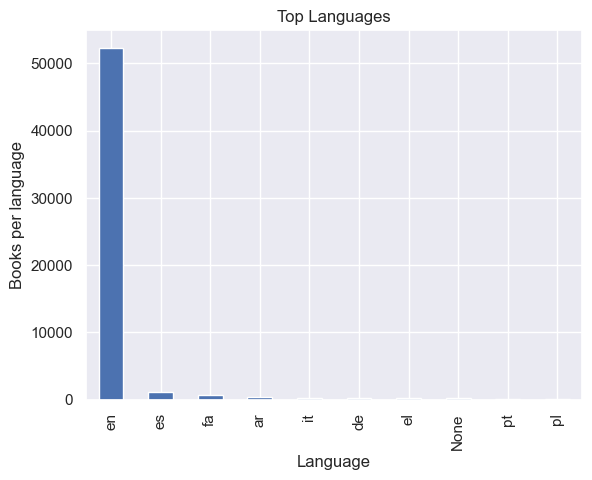

In [73]:
language_counts = reviews["review_language"].value_counts(dropna=False)

# Print the top 10 languages
print(language_counts.head(10))

language_counts.head(10).plot(kind='bar')
plt.title('Top Languages')
plt.xlabel('Language')
plt.ylabel('Books per language')
plt.show()

We can assume that reviews that are written in non-english language are not valuable of genre clustering. 

Different languages can create separate multi-lingual cluster that would spoil clustering quality (by API metrics). 

So we will drop all non-english reviews and modify original dataset.


Reduced from **57610** to **52309** reviews.

In [74]:
reviews = reviews[reviews["review_language"] == "en"]
reviews 

,id,book_id,review_text,review_language
0,1,1697,"So ""The Summerhouse"" series by Jude Deveraux i...",en
1,3,1697,The level of suspension of disbelief it takes ...,en
2,5,1697,Engaging. I didn’t want to stop reading. Very ...,en
3,7,1697,If you could go back in time - would you? Whil...,en
5,11,1697,I must admit I was extremely impressed with th...,en
...,...,...,...,...
57605,115211,1196,I see why they compare this to 50 shades I hon...,en
57606,115213,1196,"A sexy, passionate, detailed, erotic account o...",en
57607,115215,1196,Life is the Ultimate Gift. This superb book ke...,en
57608,115217,1196,Entrance by J.J. Sorel is the first book in Th...,en


Drop reviews with less than 50 chars. They are not really informative for genre clustering task.

Reduced from **52309** to **51039** reviews.

In [75]:
min_len = 50

reviews = reviews[reviews["review_text"].str.len() >= min_len]
reviews

,id,book_id,review_text,review_language
0,1,1697,"So ""The Summerhouse"" series by Jude Deveraux i...",en
1,3,1697,The level of suspension of disbelief it takes ...,en
2,5,1697,Engaging. I didn’t want to stop reading. Very ...,en
3,7,1697,If you could go back in time - would you? Whil...,en
5,11,1697,I must admit I was extremely impressed with th...,en
...,...,...,...,...
57605,115211,1196,I see why they compare this to 50 shades I hon...,en
57606,115213,1196,"A sexy, passionate, detailed, erotic account o...",en
57607,115215,1196,Life is the Ultimate Gift. This superb book ke...,en
57608,115217,1196,Entrance by J.J. Sorel is the first book in Th...,en


#### Reviews Reduction
**51039 reviews** are still too much. Is it worthy to reduce their quantity?

In [76]:
reviews_per_book = reviews.groupby("book_id").size()
reviews_per_book.describe()

count    1931.000000
mean       26.431383
std         3.862780
min         4.000000
25%        25.000000
50%        28.000000
75%        29.000000
max        30.000000
dtype: float64

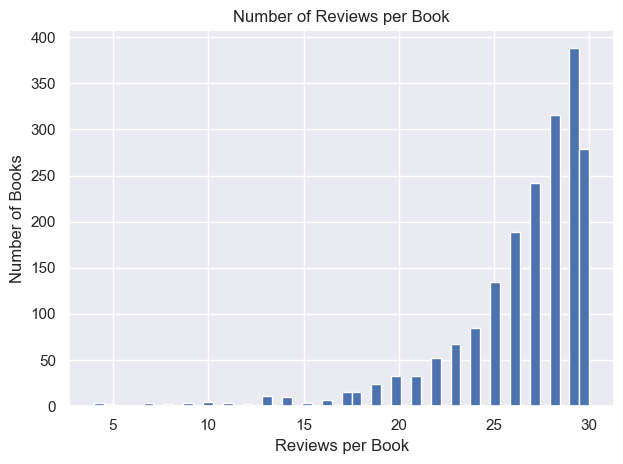

In [77]:
plt.figure()
plt.hist(reviews_per_book, bins=50)
plt.title("Number of Reviews per Book")
plt.xlabel("Reviews per Book")
plt.ylabel("Number of Books")
plt.tight_layout()
plt.show()

Let's keep only **3 concatenated reviews per book** to reduce impact over book's description.

In [78]:
MAX_REVIEWS = 3

# keep top 3 reviews per book
reviews = (
    reviews.groupby("book_id", group_keys=False)
    .apply(lambda x: x.head(MAX_REVIEWS))
)
reviews

/var/folders/1c/76y4hnt50xqdcckcrsd6y7ww0000gn/T/ipykernel_30183/3911162421.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reviews.groupby("book_id", group_keys=False)


,id,book_id,review_text,review_language
33916,67833,0,"Just to clarify: Yes, I did cry. I've read a l...",en
33917,67835,0,"THE BOOK THIEF : A Summary. Liesel: Hi, I'm Li...",en
33918,67837,0,"This is a book to treasure, a new classic. I a...",en
38252,76505,1,"Okay, I have to say that I picked this book up...",en
38253,76507,1,"Actual rating: 1.5 stars. Believe it or not, t...",en
...,...,...,...,...
47559,95119,1932,I absolutely love the Sigma Force novels by Ja...,en
47560,95121,1932,4 Stars to an Old Friend When I picked up The ...,en
53376,106753,1933,I have been reading all of the books in the Da...,en
53377,106755,1933,4 ❓❓❓❓ My rating is questionable—my bad. I sta...,en


In [79]:
# drop lang column, all reviews are in english
reviews = reviews.drop(columns=["review_language"])
reviews

,id,book_id,review_text
33916,67833,0,"Just to clarify: Yes, I did cry. I've read a l..."
33917,67835,0,"THE BOOK THIEF : A Summary. Liesel: Hi, I'm Li..."
33918,67837,0,"This is a book to treasure, a new classic. I a..."
38252,76505,1,"Okay, I have to say that I picked this book up..."
38253,76507,1,"Actual rating: 1.5 stars. Believe it or not, t..."
...,...,...,...
47559,95119,1932,I absolutely love the Sigma Force novels by Ja...
47560,95121,1932,4 Stars to an Old Friend When I picked up The ...
53376,106753,1933,I have been reading all of the books in the Da...
53377,106755,1933,4 ❓❓❓❓ My rating is questionable—my bad. I sta...


In [80]:
# agregated top 3 reviews per book
reviews = reviews.groupby("book_id")["review_text"].apply(lambda texts: " ".join(texts))
reviews

book_id
0       Just to clarify: Yes, I did cry. I've read a l...
1       Okay, I have to say that I picked this book up...
2       EMOTIONAL BLACKMAIL. You will cry, because thi...
3       Margaret Mitchell was a racist and in 1936, 70...
4       DISCLAIMER: I did not like this book. I am abo...
                              ...                        
1929    What kinda author would I be if I didn't love ...
1930    This might be the only (so-called) self-help b...
1931    This is one of these series that give the illu...
1932    The Last Oracle is the 5th book in the Sigma F...
1933    I have been reading all of the books in the Da...
Name: review_text, Length: 1931, dtype: object

### Update Books Dataset
So for clustering we will use **merged text of `description` and 3 `reviews` per book**.

Create new column `merged_text` and drop partial text columns (`description` and `reviews`).

In [81]:
# merge datasets 
books = books.merge(
    reviews,
    left_on="id",
    right_on="book_id",
    how="left"
)
books

,id,author,title,description,language,awards,reviews,review_text
0,1697,Jude Deveraux,The Summerhouse,Have you ever wanted to rewrite your past? Thr...,English,[],"[So ""The Summerhouse"" series by Jude Deveraux ...","So ""The Summerhouse"" series by Jude Deveraux i..."
1,985,Charlaine Harris,A Touch of Dead,Meet Sookie Stackhouse! Sookie Stackhouse is e...,English,[],[(B+) 76% | Good Notes: Kind of like finding a...,(B+) 76% | Good Notes: Kind of like finding an...
2,86,William Shakespeare,Macbeth,"One night on the heath, the brave and respecte...",English,[],"[Ladies and gentlemen, may I present A Thing Y...","Ladies and gentlemen, may I present A Thing Yo..."
3,439,Steven Pressfield,Gates of Fire,"At Thermopylae, a rocky mountain pass in north...",English,[],[One of the two best standalone books that I’v...,One of the two best standalone books that I’ve...
4,593,Morgan Rhodes,Falling Kingdoms,"In the three kingdoms of Mytica, magic has lon...",English,[],[Falling Kingdoms crushed my heart but exceede...,Falling Kingdoms crushed my heart but exceeded...
...,...,...,...,...,...,...,...,...
1929,292,Raz Mihal,Just Love Her,"""Just Love Her"" is a 2025 Readers' Favorite Go...",English,[],[A journey of divine essence and inspiration I...,A journey of divine essence and inspiration In...
1930,768,Tamora Pierce,Squire,Fourteen-year-old Keladry of Mindelan is not y...,English,[Margaret A. Edwards Award (2013)],[This was supposed to be the one where I let m...,This was supposed to be the one where I let my...
1931,787,Kim Harrison,For a Few Demons More,Despite dating one vampire and living with ano...,English,[],[I gave the book 3.5 score but rounded it to 3...,I gave the book 3.5 score but rounded it to 3 ...
1932,1895,Mark Cotta Vaz,Twilight: The Complete Illustrated Movie Compa...,Everything fans want to know about the hotly a...,English,[],"[By now you can see most, if not all, of the p...","By now you can see most, if not all, of the pi..."


In [82]:
# merge description and reviews
def merge_text(description, reviews_text):
    parts = []
    if isinstance(description, str) and description.strip():
        parts.append(description.strip())
    if isinstance(reviews_text, str) and reviews_text.strip():
        parts.append(reviews_text.strip())
    return " ".join(parts)

In [83]:
books["merged_text"] = books.apply(
    lambda row: merge_text(row["description"], row["review_text"]),
    axis=1
)
books

,id,author,title,description,language,awards,reviews,review_text,merged_text
0,1697,Jude Deveraux,The Summerhouse,Have you ever wanted to rewrite your past? Thr...,English,[],"[So ""The Summerhouse"" series by Jude Deveraux ...","So ""The Summerhouse"" series by Jude Deveraux i...",Have you ever wanted to rewrite your past? Thr...
1,985,Charlaine Harris,A Touch of Dead,Meet Sookie Stackhouse! Sookie Stackhouse is e...,English,[],[(B+) 76% | Good Notes: Kind of like finding a...,(B+) 76% | Good Notes: Kind of like finding an...,Meet Sookie Stackhouse! Sookie Stackhouse is e...
2,86,William Shakespeare,Macbeth,"One night on the heath, the brave and respecte...",English,[],"[Ladies and gentlemen, may I present A Thing Y...","Ladies and gentlemen, may I present A Thing Yo...","One night on the heath, the brave and respecte..."
3,439,Steven Pressfield,Gates of Fire,"At Thermopylae, a rocky mountain pass in north...",English,[],[One of the two best standalone books that I’v...,One of the two best standalone books that I’ve...,"At Thermopylae, a rocky mountain pass in north..."
4,593,Morgan Rhodes,Falling Kingdoms,"In the three kingdoms of Mytica, magic has lon...",English,[],[Falling Kingdoms crushed my heart but exceede...,Falling Kingdoms crushed my heart but exceeded...,"In the three kingdoms of Mytica, magic has lon..."
...,...,...,...,...,...,...,...,...,...
1929,292,Raz Mihal,Just Love Her,"""Just Love Her"" is a 2025 Readers' Favorite Go...",English,[],[A journey of divine essence and inspiration I...,A journey of divine essence and inspiration In...,"""Just Love Her"" is a 2025 Readers' Favorite Go..."
1930,768,Tamora Pierce,Squire,Fourteen-year-old Keladry of Mindelan is not y...,English,[Margaret A. Edwards Award (2013)],[This was supposed to be the one where I let m...,This was supposed to be the one where I let my...,Fourteen-year-old Keladry of Mindelan is not y...
1931,787,Kim Harrison,For a Few Demons More,Despite dating one vampire and living with ano...,English,[],[I gave the book 3.5 score but rounded it to 3...,I gave the book 3.5 score but rounded it to 3 ...,Despite dating one vampire and living with ano...
1932,1895,Mark Cotta Vaz,Twilight: The Complete Illustrated Movie Compa...,Everything fans want to know about the hotly a...,English,[],"[By now you can see most, if not all, of the p...","By now you can see most, if not all, of the pi...",Everything fans want to know about the hotly a...


As column `awards` not as informative as exprected (if 50%+ of books don't have awards, feature `awards` is almostly “absent”) we will drop it.

Aslo we drop `language` column, cause we agreed to use only English reviews for endlish-written books. 

In [84]:
books = books.drop(columns=["awards", "language", "reviews", "review_text"])
books

,id,author,title,description,merged_text
0,1697,Jude Deveraux,The Summerhouse,Have you ever wanted to rewrite your past? Thr...,Have you ever wanted to rewrite your past? Thr...
1,985,Charlaine Harris,A Touch of Dead,Meet Sookie Stackhouse! Sookie Stackhouse is e...,Meet Sookie Stackhouse! Sookie Stackhouse is e...
2,86,William Shakespeare,Macbeth,"One night on the heath, the brave and respecte...","One night on the heath, the brave and respecte..."
3,439,Steven Pressfield,Gates of Fire,"At Thermopylae, a rocky mountain pass in north...","At Thermopylae, a rocky mountain pass in north..."
4,593,Morgan Rhodes,Falling Kingdoms,"In the three kingdoms of Mytica, magic has lon...","In the three kingdoms of Mytica, magic has lon..."
...,...,...,...,...,...
1929,292,Raz Mihal,Just Love Her,"""Just Love Her"" is a 2025 Readers' Favorite Go...","""Just Love Her"" is a 2025 Readers' Favorite Go..."
1930,768,Tamora Pierce,Squire,Fourteen-year-old Keladry of Mindelan is not y...,Fourteen-year-old Keladry of Mindelan is not y...
1931,787,Kim Harrison,For a Few Demons More,Despite dating one vampire and living with ano...,Despite dating one vampire and living with ano...
1932,1895,Mark Cotta Vaz,Twilight: The Complete Illustrated Movie Compa...,Everything fans want to know about the hotly a...,Everything fans want to know about the hotly a...


#### Save Updated Books Dataset

In [85]:
BOOKS_CLEAN_FILENAME = "books_clean.jsonl"
books.to_json(
    BOOKS_CLEAN_FILENAME,
    orient="records",
    lines=True,
    force_ascii=False
)

### NLP
Medium article <i>"Text Clustering using NLP techniques"</i>: https://medium.com/@danielafrimi/text-clustering-using-nlp-techniques-c2e6b08b6e95

In [ ]:
!pip3 install nltk

69434.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.4 MB/s  0:00:00


In [86]:
# NLTK preprocessing
import re
import unicodedata
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

import re
import unicodedata

In [87]:
def setup():
    # Download the "punkt" tokenizer models from nltk
    nltk.download('punkt')
    nltk.download("punkt_tab")
    nltk.download("stopwords")
setup()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/viktoriiavlasenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/viktoriiavlasenko/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/viktoriiavlasenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [173]:
BOOKS_CLEAN_FILENAME = "books_clean.jsonl"

In [174]:
books = pd.read_json(BOOKS_CLEAN_FILENAME, lines=True)
books

,id,author,title,description,review_text,merged_text
0,0,Markus Zusak,The Book Thief,An alternate cover edition can be found hereIt...,"Just to clarify: Yes, I did cry. I've read a l...",An alternate cover edition can be found hereIt...
1,1,Stephenie Meyer,Twilight,About three things I was absolutely positive. ...,"Okay, I have to say that I picked this book up...",About three things I was absolutely positive. ...
2,2,John Green,The Fault in Our Stars,Despite the tumor-shrinking medical miracle th...,"EMOTIONAL BLACKMAIL. You will cry, because thi...",Despite the tumor-shrinking medical miracle th...
3,3,Margaret Mitchell,Gone with the Wind,"Scarlett O'Hara, the beautiful, spoiled daught...","Margaret Mitchell was a racist and in 1936, 70...","Scarlett O'Hara, the beautiful, spoiled daught..."
4,4,Stephen Chbosky,The Perks of Being a Wallflower,standing on the fringes of life...offers a uni...,DISCLAIMER: I did not like this book. I am abo...,standing on the fringes of life...offers a uni...
...,...,...,...,...,...,...
1929,1929,Katie Ashley,Music of the Heart,"For Abby Renard, the plan was supposed to be s...",What kinda author would I be if I didn't love ...,"For Abby Renard, the plan was supposed to be s..."
1930,1930,Oliver Burkeman,The Antidote: Happiness for People Who Can't S...,"A witty, fascinating, and counterintuitive rea...",This might be the only (so-called) self-help b...,"A witty, fascinating, and counterintuitive rea..."
1931,1931,Ian Rankin,The Falls,When a young woman goes missing near his nativ...,This is one of these series that give the illu...,When a young woman goes missing near his nativ...
1932,1932,James Rollins,The Last Oracle,"In Washington, D. C., a homeless man dies in C...",The Last Oracle is the 5th book in the Sigma F...,"In Washington, D. C., a homeless man dies in C..."


Let's try to **keep only text and standard punctuation**. It will remove noise as:
- emojis
- emoticon-like text
- excessive punctuation
- URLs
- spacing

In [175]:
def clean_text(text):
    # Remove notes
    patterns = [
        r"librarian's note:.*?(?=\.)",
        r"note:.*?(?=\.)",
        r"an alternate cover edition.*?(?=\.)"
    ]
    for p in patterns:
        text = re.sub(p, " ", text, flags=re.IGNORECASE)

    # Unicode normalization (remove emojis)
    text = unicodedata.normalize("NFKD", text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", " ", text)

    # Keep only letters, numbers and punctuation
    text = re.sub(r"[^a-zA-Z0-9\s\.\,\!\?\-\'\"]", " ", text)

    # Normalize spacing and keep lower case
    return re.sub(r"\s+", " ", text).strip().lower()

In [176]:
text_sample = books[books["id"] == 0]["merged_text"].iloc[0]

In [177]:
clean_text(text_sample)

'. nazi germany. the country is holding its breath. death has never been busier, and will be busier still. by her brother\'s graveside, liesel\'s life is changed when she picks up a single object, partially hidden in the snow. it is the gravedigger\'s handbook, left behind there by accident, and it is her first act of book thievery. so begins a love affair with books and words, as liesel, with the help of her accordian-playing foster father, learns to read. soon she is stealing books from nazi book-burnings, the mayor\'s wife\'s library, wherever there are books to be found. but these are dangerous times. when liesel\'s foster family hides a jew in their basement, liesel\'s world is both opened up, and closed down. in superbly crafted writing that burns with intensity, award-winning author markus zusak has given us one of the most enduring stories of our time. just to clarify yes, i did cry. i\'ve read a lot of positive and negative reviews for this book. i can see why people wouldn\'t

In [178]:
def preprocess(text):
    if not isinstance(text, str):
        text = ""
    text_cleaned = clean_text(text)

    # Tokenize
    tokens = word_tokenize(text_cleaned)

    # Remove stopwords and short tokens
    tokens = [
        t for t in tokens
        if t not in stop_words and len(t) > 2
    ]

    # Stemmimg
    tokens = [stemmer.stem(t) for t in tokens]

    return " ".join(tokens)

In [179]:
preprocess("This is a simple test sentence!")

'simpl test sentenc'

In [180]:
preprocess(text_sample)

"nazi germani countri hold breath death never busier busier still brother gravesid liesel life chang pick singl object partial hidden snow gravedigg handbook left behind accid first act book thieveri begin love affair book word liesel help accordian-play foster father learn read soon steal book nazi book-burn mayor wife librari wherev book found danger time liesel foster famili hide jew basement liesel world open close superbl craft write burn intens award-win author markus zusak given one endur stori time clarifi yes cri ve read lot posit negat review book see peopl would n't like realli perhap took lot person found enjoy lot quick test see ll like book like ann green gabl cope off-beat melancholi caustic dead-pan self-right narrat like word question 4-8 kind underwear re wear n't worri let gather around stori time mistress kat two incid set late neighbour came complain island australian tongan fiji papa new guinea new zealand popul australia caus troubl otherwis defil great beauti na

#### Apply preprocessing
Apply preprocessing for `description` and `merged_text` features.

The preprocessed features `description_nlp` and `merged_text_npl` will represent main input strategies:
- **Strategy A**: preprocessed book description;
- **Strategy B**: preprocessed description + 3 reviews (merged n preprocessed);
- **Strategy C**: all reviews.

In [ ]:
books['description_nlp'] = books['description'].apply(lambda text: preprocess(text))
books['merged_text_nlp'] = books['merged_text'].apply(lambda text: preprocess(text))
books['review_text_nlp'] = books['review_text'].apply(lambda text: preprocess(text))
books

,id,author,title,description,review_text,merged_text,description_nlp,merged_text_nlp,review_text_nlp
0,0,Markus Zusak,The Book Thief,An alternate cover edition can be found hereIt...,"Just to clarify: Yes, I did cry. I've read a l...",An alternate cover edition can be found hereIt...,nazi germani countri hold breath death never b...,nazi germani countri hold breath death never b...,clarifi yes cri ve read lot posit negat review...
1,1,Stephenie Meyer,Twilight,About three things I was absolutely positive. ...,"Okay, I have to say that I picked this book up...",About three things I was absolutely positive. ...,three thing absolut posit first edward vampir ...,three thing absolut posit first edward vampir ...,okay say pick book part due hype part involv t...
2,2,John Green,The Fault in Our Stars,Despite the tumor-shrinking medical miracle th...,"EMOTIONAL BLACKMAIL. You will cry, because thi...",Despite the tumor-shrinking medical miracle th...,despit tumor-shrink medic miracl bought year h...,despit tumor-shrink medic miracl bought year h...,emot blackmail cri sad discuss occur head rate...
3,3,Margaret Mitchell,Gone with the Wind,"Scarlett O'Hara, the beautiful, spoiled daught...","Margaret Mitchell was a racist and in 1936, 70...","Scarlett O'Hara, the beautiful, spoiled daught...",scarlett o'hara beauti spoil daughter well-to-...,scarlett o'hara beauti spoil daughter well-to-...,margaret mitchel racist 1936 year civil war wr...
4,4,Stephen Chbosky,The Perks of Being a Wallflower,standing on the fringes of life...offers a uni...,DISCLAIMER: I did not like this book. I am abo...,standing on the fringes of life...offers a uni...,stand fring life ... offer uniqu perspect come...,stand fring life ... offer uniqu perspect come...,disclaim like book tri explain person review s...
...,...,...,...,...,...,...,...,...,...
1929,1929,Katie Ashley,Music of the Heart,"For Abby Renard, the plan was supposed to be s...",What kinda author would I be if I didn't love ...,"For Abby Renard, the plan was supposed to be s...",abbi renard plan suppos simpl join brother ban...,abbi renard plan suppos simpl join brother ban...,kinda author would n't love book huh n't wait ...
1930,1930,Oliver Burkeman,The Antidote: Happiness for People Who Can't S...,"A witty, fascinating, and counterintuitive rea...",This might be the only (so-called) self-help b...,"A witty, fascinating, and counterintuitive rea...",witti fascin counterintuit read turn decad sel...,witti fascin counterintuit read turn decad sel...,might so-cal self-help book includ quot wire b...
1931,1931,Ian Rankin,The Falls,When a young woman goes missing near his nativ...,This is one of these series that give the illu...,When a young woman goes missing near his nativ...,young woman goe miss near nativ edinburgh scot...,young woman goe miss near nativ edinburgh scot...,one seri give illus extraordinari depth charac...
1932,1932,James Rollins,The Last Oracle,"In Washington, D. C., a homeless man dies in C...",The Last Oracle is the 5th book in the Sigma F...,"In Washington, D. C., a homeless man dies in C...",washington homeless man die command gray pierc...,washington homeless man die command gray pierc...,last oracl 5th book sigma forc seri written ja...


#### Save Preprocessed Dataset

In [241]:
BOOKS_PREPROCESSED_FILENAME = "books_preprocessed.jsonl"
books.to_json(
    BOOKS_PREPROCESSED_FILENAME,
    orient="records",
    lines=True,
    force_ascii=False
)

#### TF-IDF Vectorization and Feature Engineering
Reference: https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py

In [128]:
!pip3 install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 5.7 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scikit-learn] [scikit-learn]


In [183]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
RANDOM_STATE = 42

**TfidfVectorizer Parameters**

We will use a dictionary vectorizer along with an IDF normalization as provided by `sklearn.feature_extraction.text.TfidfVectorizer` with the following parameters:
- `ngram_range=(1,2)` is fow 2 words genre
- ignoring terms that appear in more than 90% of the documents (as set by `max_df=0.9`) 
- and terms that are not present in at least 3 documents (set by `min_df=3`).

In the context of **text data**, each unique word across all documents could be treated as a distinct feature. However, each document will only include a small subset of these available features or unique words. Meaning, most entries in feature matrix end up being 0s, hence resulting in a **sparse matrix**.

**Dimensionality Reduction**

The processed text is transformed into a feature matrix using techniques like **TF-IDF representation**. But these matrices are **often high-dimensional**, which increases the complexity of the model, causes longer training times, and can even degrade model performance due to the so-called “curse of dimensionality”. To address these issues, we will use Dimensionality Reduction technique as `TruncatedSVD` which **reduce the size of the feature space**.


**References**:

- Efficient Text Data Representation with Sparse Matrix. https://codesignal.com/learn/courses/feature-engineering-for-text-classification/lessons/efficient-text-data-representation-with-sparse-matrices
- Is there any situation where PCA performs better than SVD? https://stats.stackexchange.com/questions/202036/is-there-any-situation-where-pca-performs-better-than-svd
- How to choose n_component in TruncatedSVD? https://stackoverflow.com/questions/75423002/how-to-choose-n-component-in-truncatedsvd

In [99]:
def build_text_features(texts: pd.Series,
                        ngram_range=(1,2),
                        min_df=3,
                        max_df=0.9,
                        svd_dim=300):
    tfidf = TfidfVectorizer(
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df,
        # cancel frequent words
        # tf = 1 + log(tf)
        sublinear_tf=True,
        # cosine similarity
        norm="l2"
    )
    X_tfidf = tfidf.fit_transform(texts.fillna(""))

    # dim reduction with truncated SVD
    svd = TruncatedSVD(n_components=svd_dim, random_state=RANDOM_STATE)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X_lsa = lsa.fit_transform(X_tfidf)

    return X_tfidf, X_lsa, tfidf, lsa

*Hyperparameter*: `n_components` is a `svd_dim` parameter in the function `build_text_features`.

In [189]:
X_tfidf_A, X_lsa_A, tfidf_A, lsa_A = build_text_features(books.description_nlp, svd_dim=300)
X_tfidf_B, X_lsa_B, tfidf_B, lsa_B = build_text_features(books.merged_text_nlp, svd_dim=300)

## 3. Apply an unsupervised clustering algorithm to group books into meaningful categories.

Genres
Art
Biography
Business
Children's
Christian
Classics
Comics
Cookbooks
Ebooks
Fantasy
Fiction
Graphic Novels
Historical Fiction
History
Horror
Memoir
Music
Mystery
Nonfiction
Poetry
Psychology
Romance
Science
Science Fiction
Self Help
Sports
Thriller
Travel
Young Adult
More Genres

Medium article <i>"Clustering the Classics: What Grouping Books by Rating and Genres Reveals"</i>: https://medium.com/inst414-data-science-tech/clustering-the-classics-what-grouping-books-by-rating-and-genres-reveals-39111c1d42dc

Github repo reference: https://github.com/col-shan/INST414_Modules/blob/7022747aa2b901bd04821ec640e1de20e43597a0/Module_4.ipynb?source=post_page-----39111c1d42dc---------------------------------------


In [22]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

#### Load preprocessed dataset

In [242]:
books = pd.read_json(BOOKS_PREPROCESSED_FILENAME, lines=True)
books

,id,author,title,description,review_text,merged_text,description_nlp,merged_text_nlp,review_text_nlp
0,0,Markus Zusak,The Book Thief,An alternate cover edition can be found hereIt...,"Just to clarify: Yes, I did cry. I've read a l...",An alternate cover edition can be found hereIt...,nazi germani countri hold breath death never b...,nazi germani countri hold breath death never b...,clarifi yes cri ve read lot posit negat review...
1,1,Stephenie Meyer,Twilight,About three things I was absolutely positive. ...,"Okay, I have to say that I picked this book up...",About three things I was absolutely positive. ...,three thing absolut posit first edward vampir ...,three thing absolut posit first edward vampir ...,okay say pick book part due hype part involv t...
2,2,John Green,The Fault in Our Stars,Despite the tumor-shrinking medical miracle th...,"EMOTIONAL BLACKMAIL. You will cry, because thi...",Despite the tumor-shrinking medical miracle th...,despit tumor-shrink medic miracl bought year h...,despit tumor-shrink medic miracl bought year h...,emot blackmail cri sad discuss occur head rate...
3,3,Margaret Mitchell,Gone with the Wind,"Scarlett O'Hara, the beautiful, spoiled daught...","Margaret Mitchell was a racist and in 1936, 70...","Scarlett O'Hara, the beautiful, spoiled daught...",scarlett o'hara beauti spoil daughter well-to-...,scarlett o'hara beauti spoil daughter well-to-...,margaret mitchel racist 1936 year civil war wr...
4,4,Stephen Chbosky,The Perks of Being a Wallflower,standing on the fringes of life...offers a uni...,DISCLAIMER: I did not like this book. I am abo...,standing on the fringes of life...offers a uni...,stand fring life ... offer uniqu perspect come...,stand fring life ... offer uniqu perspect come...,disclaim like book tri explain person review s...
...,...,...,...,...,...,...,...,...,...
1929,1929,Katie Ashley,Music of the Heart,"For Abby Renard, the plan was supposed to be s...",What kinda author would I be if I didn't love ...,"For Abby Renard, the plan was supposed to be s...",abbi renard plan suppos simpl join brother ban...,abbi renard plan suppos simpl join brother ban...,kinda author would n't love book huh n't wait ...
1930,1930,Oliver Burkeman,The Antidote: Happiness for People Who Can't S...,"A witty, fascinating, and counterintuitive rea...",This might be the only (so-called) self-help b...,"A witty, fascinating, and counterintuitive rea...",witti fascin counterintuit read turn decad sel...,witti fascin counterintuit read turn decad sel...,might so-cal self-help book includ quot wire b...
1931,1931,Ian Rankin,The Falls,When a young woman goes missing near his nativ...,This is one of these series that give the illu...,When a young woman goes missing near his nativ...,young woman goe miss near nativ edinburgh scot...,young woman goe miss near nativ edinburgh scot...,one seri give illus extraordinari depth charac...
1932,1932,James Rollins,The Last Oracle,"In Washington, D. C., a homeless man dies in C...",The Last Oracle is the 5th book in the Sigma F...,"In Washington, D. C., a homeless man dies in C...",washington homeless man die command gray pierc...,washington homeless man die command gray pierc...,last oracl 5th book sigma forc seri written ja...


### Submission
Functions for generating submission file.

In [102]:
def create_submission(labels, filename="submission.csv"):
    # Prepare submission dataframe
    submission = pd.DataFrame({
        "ID": books["id"].astype(int),
        "TARGET": labels.astype(int)
    })
    # save to csv
    submission.to_csv(filename, index=False)
    return submission

### Elbow method for choosing the number of clusters

#### Elbow Method for KMeans

In K-Means clustering, **Inertia** (also called Within-Cluster Sum of Squares or WCSS) measures the compactness of clusters by summing the squared distances from each point to its cluster's centroid; 

the Elbow Method uses this metric to **find the optimal number of clusters (K)** by plotting inertia against K, looking for the **"elbow" point** where inertia's decrease slows significantly, indicating diminishing returns for adding more clusters. 

Reference: Aris' notebook *wine_pca_kmeans_lab-full.ipynb*.

In [18]:
from sklearn.cluster import KMeans

In [187]:
# set min and max number of clusters for 1934 books
k_values = range(20, 80, 5)

In [104]:
def choose_k_elbow_kmeans(X_lsa):

    def calculate_and_plot_inertias(X_lsa):
        inertias = []

        for k in k_values:
            kmeans = KMeans(
                n_clusters=k,
                init="k-means++",
                n_init="auto",
                random_state=RANDOM_STATE
            )
            kmeans.fit(X_lsa)
            inertias.append(kmeans.inertia_)

        # Plot elbow
        plt.figure(figsize=(7, 4))
        plt.plot(list(k_values), inertias, marker='o')
        plt.xlabel("Number of clusters (k)")
        plt.ylabel("Inertia (within-cluster SSE)")
        plt.title("Elbow Method for K-Means++ (LSA features)")
        plt.xticks(list(k_values))
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        return inertias

    ks = np.array(list(k_values))
    inertias_arr = np.array(calculate_and_plot_inertias(X_lsa))

    # Line between first and last points
    p1 = np.array([ks[0], inertias_arr[0]])
    p2 = np.array([ks[-1], inertias_arr[-1]])

    line = p2 - p1
    line_norm = np.linalg.norm(line)

    distances = []
    for k, inertia in zip(ks, inertias_arr):
        p = np.array([k, inertia])
        # distance from point to lines
        cross_mag = abs(
            line[0] * (p1[1] - p[1]) -
            line[1] * (p1[0] - p[0])
        )
        dist = cross_mag / line_norm
        distances.append(dist)

    best_k = ks[np.argmax(distances)]
    print(f"The best k for K-Means++: {best_k}")
    return best_k

**Strategy A**

With *hyperparameter* `n_components = 300`.

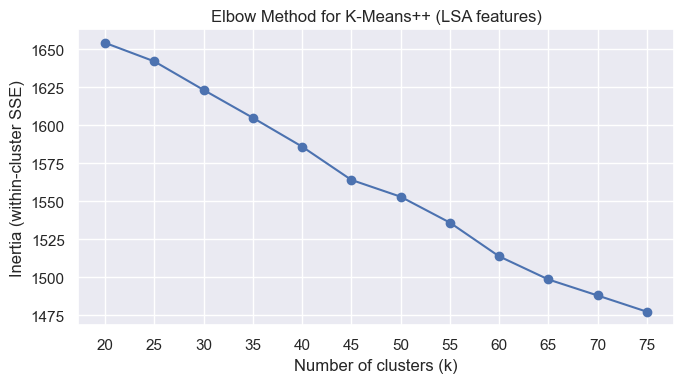

The best k for K-Means++: 60


np.int64(60)

In [190]:
best_k = choose_k_elbow_kmeans(X_lsa_A)
best_k

**Strategy B**

With *hyperparameter* `n_components = 300`.

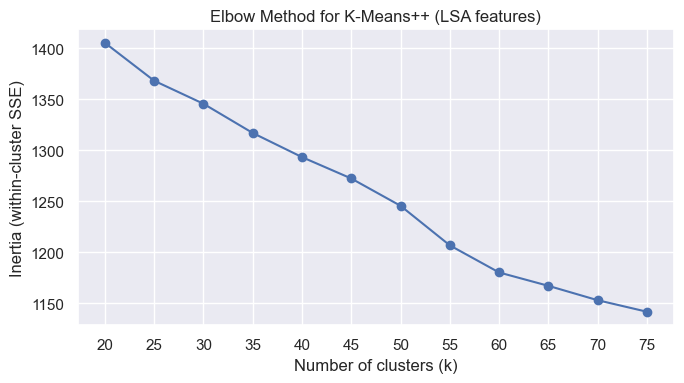

The best k for K-Means++: 60


np.int64(60)

In [191]:
best_k = choose_k_elbow_kmeans(X_lsa_B)
best_k

**The elbow curve does not show a sharp inflection point**. We can suppose that it will be reasonably to choose `k = 60` or `k = 45` on this point. Obviously number of clusters can be adjusted.

#### The Eigengap Heuristic for Spectral Clustering

From *“A Tutorial on Spectral Clustering” (2007)*:

> “One tool which is particularly designed for spectral clustering is the **eigengap heuristic**. Here the goal is to choose the number $k$ such that all eigenvalues $\lambda_1, \ldots, \lambda_k$ are very small, but $\lambda_{k+1}$ is relatively large.” 

**Reference**: 
- Spectral graph clustering and optimal number of clusters estimation. https://medium.com/data-science/spectral-graph-clustering-and-optimal-number-of-clusters-estimation-32704189afbe
- A Tutorial on Spectral Clustering. https://arxiv.org/pdf/0711.0189


In [36]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

In [107]:
def build_laplasian_graph(X_lsa):
    # Build similarity matrix
    W = cosine_similarity(X_lsa)
    np.fill_diagonal(W, 0.0)

    # Build normalized Laplacian graph
    return csgraph.laplacian(W, normed=True)

In [108]:
# Compute eigenvalues
def compute_eigengap(L_sym, k_max=120):
    eigenvals, _ = eigsh(L_sym, k=k_max, which="SM")
    eigenvals = np.sort(eigenvals)
    gaps = np.diff(eigenvals)
    return [eigenvals, gaps]

In [109]:
def choose_k_eigengap(L_sym, k_min=5, k_max=120, plot=True):
    eigenvals, gaps = compute_eigengap(L_sym, k_max)
    
    ks = np.arange(1, len(gaps) + 1)
    
    # restrict to reasonable range
    valid = (ks >= k_min)
    ks_valid = ks[valid]
    gaps_valid = gaps[valid]
    
    best_k = ks_valid[np.argmax(gaps_valid)]
    
    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(7,4))
        plt.plot(ks, gaps, marker="o")
        plt.axvline(best_k, color="red", linestyle="--", label=f"k={best_k}")
        plt.xlabel("k")
        plt.ylabel("Eigengap λ(k+1) − λ(k)")
        plt.title("Eigengap heuristic for Spectral Clustering")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    return best_k

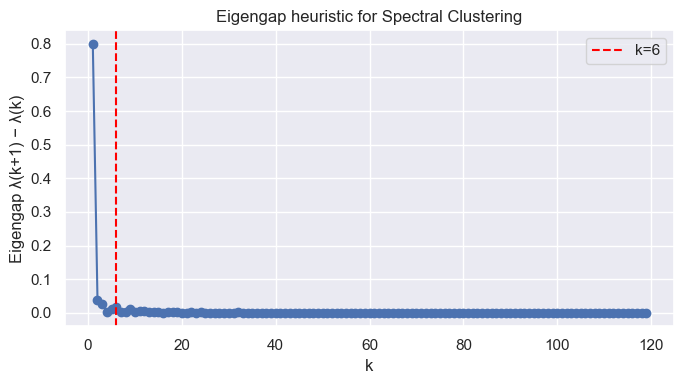

np.int64(6)

In [110]:
L_sym = build_laplasian_graph(X_lsa_A)
k_spectral = choose_k_eigengap(L_sym, k_min=5, k_max=120)
k_spectral

**Why $k = 6$?????**

If clusters are not well separated, the eigengap heuristic may suggest a small number of clusters corresponding only to the strongest structures. 
> If clusters are not well separated, the eigengap heuristic may suggest a small number of clusters corresponding only to the strongest structures.

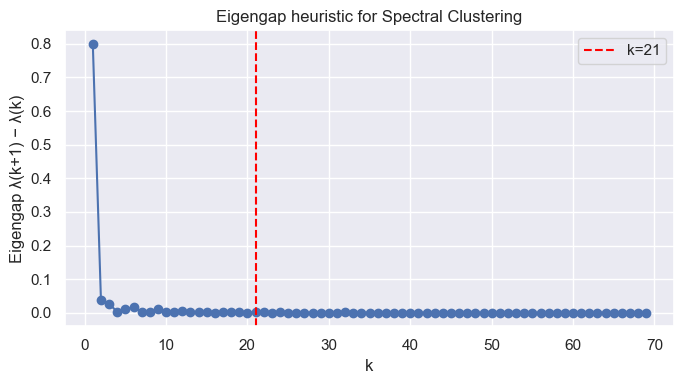

np.int64(21)

In [192]:
L_sym = build_laplasian_graph(X_lsa_A)
k_spectral = choose_k_eigengap(L_sym, k_min=20, k_max=70)
k_spectral

On a straighter range for $k$ eigengap heuristic shows "more reasonable" $k = 21$.

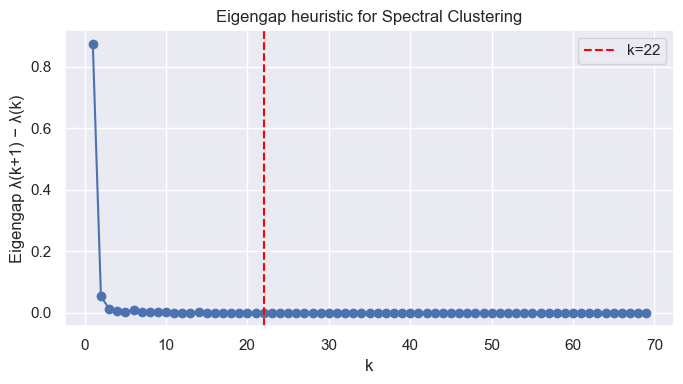

np.int64(22)

In [193]:
L_sym = build_laplasian_graph(X_lsa_B)
k_spectral = choose_k_eigengap(L_sym, k_min=20, k_max=70)
k_spectral

So for the **Strategy A** $k=21$ and for **Strategy B** $k=26$.

### K-means clustering on text features
Reference: https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py

In [42]:
from sklearn.cluster import KMeans

In [114]:
def run_kmeans(X_lsa, k):
    km = KMeans(n_clusters=k, init="k-means++", n_init="auto", random_state=RANDOM_STATE)
    labels = km.fit_predict(X_lsa)
    return labels, km.cluster_centers_

*Hyperparameters*:
- *feature*: `description_nlp` or `merged_text_nlp`
- *SVD dimensionality*: `n_components`
- *number of clusters by Elbow method*: `k_km`

In [44]:
svd_dim = 300

**Strategy A**

In [202]:
# Build features
X_tfidf, X_lsa, tfidf, lsa = build_text_features(books.description_nlp, svd_dim=svd_dim)

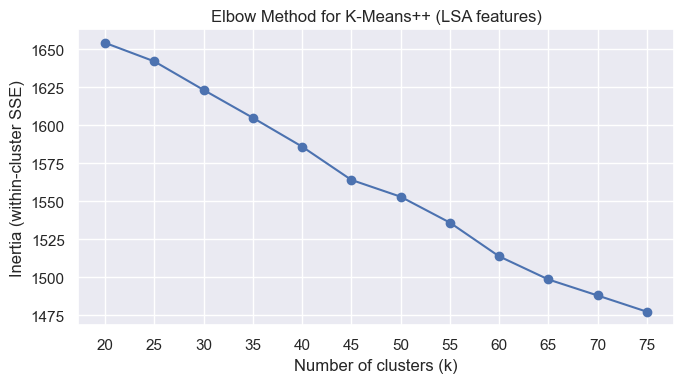

The best k for K-Means++: 60
Cluster label counts:
Cluster 0: 20 samples
Cluster 1: 11 samples
Cluster 2: 54 samples
Cluster 3: 33 samples
Cluster 4: 126 samples
Cluster 5: 46 samples
Cluster 6: 28 samples
Cluster 7: 34 samples
Cluster 8: 22 samples
Cluster 9: 32 samples
Cluster 10: 22 samples
Cluster 11: 38 samples
Cluster 12: 45 samples
Cluster 13: 12 samples
Cluster 14: 11 samples
Cluster 15: 39 samples
Cluster 16: 97 samples
Cluster 17: 15 samples
Cluster 18: 17 samples
Cluster 19: 68 samples
Cluster 20: 63 samples
Cluster 21: 40 samples
Cluster 22: 14 samples
Cluster 23: 36 samples
Cluster 24: 63 samples
Cluster 25: 61 samples
Cluster 26: 40 samples
Cluster 27: 12 samples
Cluster 28: 20 samples
Cluster 29: 17 samples
Cluster 30: 13 samples
Cluster 31: 70 samples
Cluster 32: 28 samples
Cluster 33: 8 samples
Cluster 34: 5 samples
Cluster 35: 33 samples
Cluster 36: 16 samples
Cluster 37: 14 samples
Cluster 38: 55 samples
Cluster 39: 25 samples
Cluster 40: 7 samples
Cluster 41: 16 sam

,ID,TARGET
0,0,25
1,1,22
2,2,35
3,3,5
4,4,28
...,...,...
1929,1929,51
1930,1930,31
1931,1931,55
1932,1932,11


In [203]:
# Choose best k by Elbow Method
k_km = choose_k_elbow_kmeans(X_lsa)

# K-Means++ clustering
km_labels, km_centers = run_kmeans(X_lsa, k_km)

# Print clusters info
print("Cluster label counts:")
unique, counts = np.unique(km_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

# Prepare submission dataframe
create_submission(km_labels)

**Choose k based on Kaggle ARI**

In [212]:
# Choose best k by Kaggle
k_km = 60

# K-Means++ clustering
km_labels, km_centers = run_kmeans(X_lsa, k_km)

# Print clusters info
print("Cluster label counts:")
unique, counts = np.unique(km_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

# Prepare submission dataframe
create_submission(km_labels, f"submission-kmeans-description-{k_km}.csv")

Cluster label counts:
Cluster 0: 20 samples
Cluster 1: 11 samples
Cluster 2: 54 samples
Cluster 3: 33 samples
Cluster 4: 126 samples
Cluster 5: 46 samples
Cluster 6: 28 samples
Cluster 7: 34 samples
Cluster 8: 22 samples
Cluster 9: 32 samples
Cluster 10: 22 samples
Cluster 11: 38 samples
Cluster 12: 45 samples
Cluster 13: 12 samples
Cluster 14: 11 samples
Cluster 15: 39 samples
Cluster 16: 97 samples
Cluster 17: 15 samples
Cluster 18: 17 samples
Cluster 19: 68 samples
Cluster 20: 63 samples
Cluster 21: 40 samples
Cluster 22: 14 samples
Cluster 23: 36 samples
Cluster 24: 63 samples
Cluster 25: 61 samples
Cluster 26: 40 samples
Cluster 27: 12 samples
Cluster 28: 20 samples
Cluster 29: 17 samples
Cluster 30: 13 samples
Cluster 31: 70 samples
Cluster 32: 28 samples
Cluster 33: 8 samples
Cluster 34: 5 samples
Cluster 35: 33 samples
Cluster 36: 16 samples
Cluster 37: 14 samples
Cluster 38: 55 samples
Cluster 39: 25 samples
Cluster 40: 7 samples
Cluster 41: 16 samples
Cluster 42: 16 samples
C

,ID,TARGET
0,0,25
1,1,22
2,2,35
3,3,5
4,4,28
...,...,...
1929,1929,51
1930,1930,31
1931,1931,55
1932,1932,11


**Strategy B**

In [213]:
# Build features
X_tfidf, X_lsa, tfidf, lsa = build_text_features(books.merged_text_nlp, svd_dim=svd_dim)

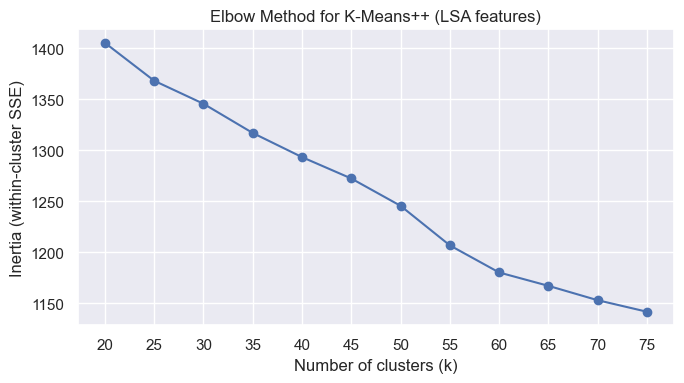

The best k for K-Means++: 60
Cluster label counts:
Cluster 0: 20 samples
Cluster 1: 26 samples
Cluster 2: 111 samples
Cluster 3: 64 samples
Cluster 4: 47 samples
Cluster 5: 107 samples
Cluster 6: 39 samples
Cluster 7: 15 samples
Cluster 8: 18 samples
Cluster 9: 26 samples
Cluster 10: 14 samples
Cluster 11: 26 samples
Cluster 12: 57 samples
Cluster 13: 17 samples
Cluster 14: 19 samples
Cluster 15: 18 samples
Cluster 16: 21 samples
Cluster 17: 99 samples
Cluster 18: 42 samples
Cluster 19: 18 samples
Cluster 20: 12 samples
Cluster 21: 29 samples
Cluster 22: 31 samples
Cluster 23: 50 samples
Cluster 24: 33 samples
Cluster 25: 15 samples
Cluster 26: 102 samples
Cluster 27: 10 samples
Cluster 28: 13 samples
Cluster 29: 22 samples
Cluster 30: 12 samples
Cluster 31: 28 samples
Cluster 32: 10 samples
Cluster 33: 8 samples
Cluster 34: 13 samples
Cluster 35: 12 samples
Cluster 36: 39 samples
Cluster 37: 20 samples
Cluster 38: 10 samples
Cluster 39: 64 samples
Cluster 40: 13 samples
Cluster 41: 34

,ID,TARGET
0,0,49
1,1,56
2,2,1
3,3,2
4,4,2
...,...,...
1929,1929,59
1930,1930,39
1931,1931,43
1932,1932,15


In [214]:
# Choose best k by Elbow Method
k_km = choose_k_elbow_kmeans(X_lsa)

# K-Means++ clustering
km_labels, km_centers = run_kmeans(X_lsa, k_km)

# Print clusters info
print("Cluster label counts:")
unique, counts = np.unique(km_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

# Prepare submission dataframe
create_submission(km_labels)

**Choose k based on Kaggle ARI**

In [ ]:
# Choose best k by Kaggle
k_km = 25

# K-Means++ clustering
km_labels, km_centers = run_kmeans(X_lsa, k_km)

# Print clusters info
print("Cluster label counts:")
unique, counts = np.unique(km_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

# Prepare submission dataframe
create_submission(km_labels, f"submission-kmeans-merged-{k_km}.csv")

Cluster label counts:
Cluster 0: 20 samples
Cluster 1: 116 samples
Cluster 2: 111 samples
Cluster 3: 17 samples
Cluster 4: 80 samples
Cluster 5: 170 samples
Cluster 6: 350 samples
Cluster 7: 17 samples
Cluster 8: 13 samples
Cluster 9: 153 samples
Cluster 10: 18 samples
Cluster 11: 24 samples
Cluster 12: 91 samples
Cluster 13: 43 samples
Cluster 14: 67 samples
Cluster 15: 70 samples
Cluster 16: 14 samples
Cluster 17: 101 samples
Cluster 18: 22 samples
Cluster 19: 87 samples
Cluster 20: 129 samples
Cluster 21: 82 samples
Cluster 22: 50 samples
Cluster 23: 18 samples
Cluster 24: 71 samples


,ID,TARGET
0,0,5
1,1,6
2,2,20
3,3,5
4,4,2
...,...,...
1929,1929,9
1930,1930,17
1931,1931,19
1932,1932,8


**Strategy C**

With *hyperparameter* `n_components = 300`.

In [243]:
# Build features
X_tfidf, X_lsa, tfidf, lsa = build_text_features(books.review_text_nlp, svd_dim=svd_dim)

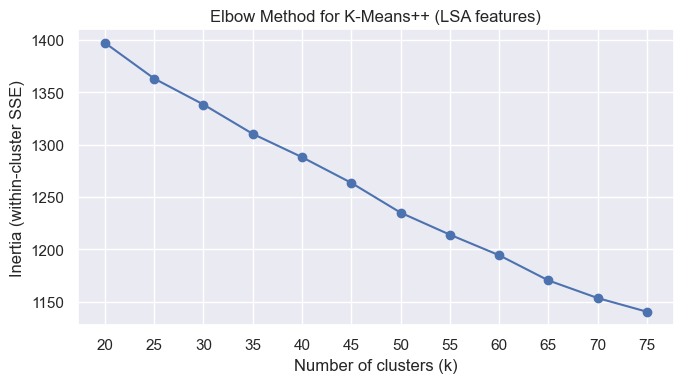

The best k for K-Means++: 50
Cluster label counts:
Cluster 0: 20 samples
Cluster 1: 51 samples
Cluster 2: 99 samples
Cluster 3: 9 samples
Cluster 4: 60 samples
Cluster 5: 67 samples
Cluster 6: 92 samples
Cluster 7: 9 samples
Cluster 8: 22 samples
Cluster 9: 74 samples
Cluster 10: 66 samples
Cluster 11: 10 samples
Cluster 12: 18 samples
Cluster 13: 109 samples
Cluster 14: 24 samples
Cluster 15: 49 samples
Cluster 16: 30 samples
Cluster 17: 82 samples
Cluster 18: 11 samples
Cluster 19: 29 samples
Cluster 20: 19 samples
Cluster 21: 11 samples
Cluster 22: 14 samples
Cluster 23: 7 samples
Cluster 24: 25 samples
Cluster 25: 13 samples
Cluster 26: 17 samples
Cluster 27: 71 samples
Cluster 28: 84 samples
Cluster 29: 32 samples
Cluster 30: 8 samples
Cluster 31: 27 samples
Cluster 32: 12 samples
Cluster 33: 20 samples
Cluster 34: 76 samples
Cluster 35: 65 samples
Cluster 36: 119 samples
Cluster 37: 20 samples
Cluster 38: 14 samples
Cluster 39: 32 samples
Cluster 40: 34 samples
Cluster 41: 4 samp

,ID,TARGET
0,0,9
1,1,38
2,2,1
3,3,29
4,4,2
...,...,...
1929,1929,46
1930,1930,10
1931,1931,19
1932,1932,15


In [244]:
# Choose best k by Elbow Method
k_km = choose_k_elbow_kmeans(X_lsa)

# K-Means++ clustering
km_labels, km_centers = run_kmeans(X_lsa, k_km)

# Print clusters info
print("Cluster label counts:")
unique, counts = np.unique(km_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

# Prepare submission dataframe
create_submission(km_labels)

**Choose k based on Kaggle ARI**

In [252]:
# Choose best k by Kaggle
k_km = 60

# K-Means++ clustering
km_labels, km_centers = run_kmeans(X_lsa, k_km)

# Print clusters info
print("Cluster label counts:")
unique, counts = np.unique(km_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")

# Prepare submission dataframe
create_submission(km_labels, f"submission-kmeans-reviews-{k_km}.csv")

Cluster label counts:
Cluster 0: 20 samples
Cluster 1: 51 samples
Cluster 2: 95 samples
Cluster 3: 60 samples
Cluster 4: 29 samples
Cluster 5: 152 samples
Cluster 6: 57 samples
Cluster 7: 33 samples
Cluster 8: 34 samples
Cluster 9: 153 samples
Cluster 10: 49 samples
Cluster 11: 18 samples
Cluster 12: 43 samples
Cluster 13: 15 samples
Cluster 14: 21 samples
Cluster 15: 113 samples
Cluster 16: 18 samples
Cluster 17: 19 samples
Cluster 18: 61 samples
Cluster 19: 35 samples
Cluster 20: 30 samples
Cluster 21: 110 samples
Cluster 22: 44 samples
Cluster 23: 19 samples
Cluster 24: 24 samples
Cluster 25: 18 samples
Cluster 26: 6 samples
Cluster 27: 10 samples
Cluster 28: 23 samples
Cluster 29: 52 samples
Cluster 30: 12 samples
Cluster 31: 14 samples
Cluster 32: 14 samples
Cluster 33: 10 samples
Cluster 34: 13 samples
Cluster 35: 9 samples
Cluster 36: 25 samples
Cluster 37: 5 samples
Cluster 38: 30 samples
Cluster 39: 10 samples
Cluster 40: 7 samples
Cluster 41: 39 samples
Cluster 42: 42 samples

,ID,TARGET
0,0,19
1,1,52
2,2,1
3,3,24
4,4,2
...,...,...
1929,1929,15
1930,1930,8
1931,1931,27
1932,1932,17


#### Visualize clusters in PCA space

In [148]:
from sklearn.decomposition import PCA

**2D PCA projection**

For visualization, we project the dataset onto the first **two** principal components.

In [146]:
def create_2d_PCA_projection(X_lsa, pca_num_components=2):
    # 2D PCA space
    pca_2d = PCA(
        n_components=pca_num_components, 
        random_state=RANDOM_STATE
    )
    # points projection
    X_pca_2d = pca_2d.fit_transform(X_lsa)
    print("Shape of 2D PCA projection:", X_pca_2d.shape)

    # Project cluster centers into the same 2D PCA space
    centers_pca = pca_2d.transform(km_centers)
    return X_pca_2d, centers_pca

In [225]:
X_pca_2d, centers_pca = create_2d_PCA_projection(X_lsa)

Shape of 2D PCA projection: (1934, 2)


/var/folders/1c/76y4hnt50xqdcckcrsd6y7ww0000gn/T/ipykernel_30183/2384343878.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Paired")


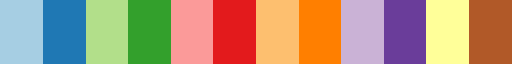

In [150]:
cmap = plt.cm.get_cmap("Paired")
cmap

In [227]:
def plot_clusters(X_pca_2d, km_labels, centers_pca):
    plt.figure(figsize=(8, 6))

    # plot points
    sc = plt.scatter(
        X_pca_2d[:, 0],
        X_pca_2d[:, 1],
        c=km_labels,
        cmap=cmap,
        s=40,
        alpha=0.7
    )

    # plot centroids
    plt.scatter(
        centers_pca[:, 0],
        centers_pca[:, 1],
        marker='X',
        s=260,
        c='black',
        edgecolor='white',
        linewidth=1.2,
        zorder=5
    )

    # annotate centroids
    for i, (x, y) in enumerate(centers_pca):
        plt.text(
            x, y,
            f'C{i}',
            fontsize=9,
            fontweight='bold',
            ha='center',
            va='center',
            color='white',
            zorder=6,
            bbox=dict(
                boxstyle="round,pad=0.25",
                fc="black",
                ec="none",
                alpha=0.75
            )
        )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("K-Means Clusters: 2D PCA Projection")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

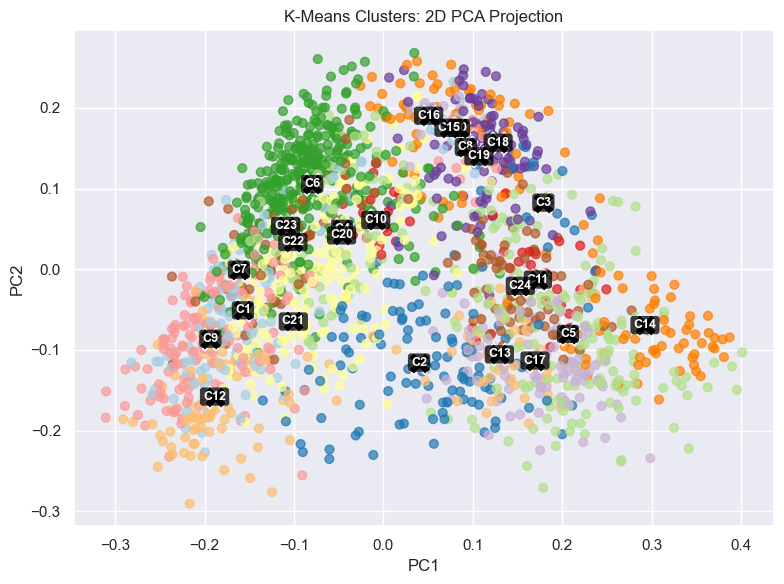

In [228]:
plot_clusters(X_pca_2d, km_labels, centers_pca)

The **eigengap heuristic** identifies only a **small number of dominant clusters** ($k = 6$), indicating that the similarity graph is largely connected with no strong global separations. This behavior is proved with the 2D PCA visualization, that **shows a big dense cloud with overlapping K-Means clusters** instead of clearly separated components. As **spectral clustering captures only globally stable partitions**, it naturally yields a smaller number of clusters compared to K-Means, which enforces a predefined (where we choose k ourselves) partitioning of the data.

(1934, `n_components`)

($k$, `n_components`)

($k$, 2)

In [229]:
print(X_lsa.shape)
print(km_centers.shape)
print(centers_pca.shape)

(1934, 300)
(25, 300)
(25, 2)


### Spectral Clustering

**Reference**:
- A Tutorial on Spectral Clustering. https://arxiv.org/pdf/0711.0189

In [154]:
from sklearn.cluster import SpectralClustering

In [230]:
def run_spectral(X_lsa, k, n_neighbors=25):
    sc = SpectralClustering(
        n_clusters=k,
        affinity="nearest_neighbors",
        n_neighbors=n_neighbors,
        assign_labels="kmeans",
        random_state=RANDOM_STATE,
    )
    labels = sc.fit_predict(X_lsa)
    return labels

In [239]:
k_sp = 60
spectral_labels = run_spectral(X_lsa, k=k_sp)
create_submission(spectral_labels, f"submission-spectral-merged-{k_sp}.csv")

,ID,TARGET
0,0,4
1,1,8
2,2,58
3,3,4
4,4,1
...,...,...
1929,1929,48
1930,1930,44
1931,1931,29
1932,1932,2


#### Visualize clusters in PCA space

In [232]:
def plot_clusters(X_pca_2d, labels, title="Spectral Clustering: 2D PCA Projection"):
    plt.figure(figsize=(8, 6))

    plt.scatter(
        X_pca_2d[:, 0],
        X_pca_2d[:, 1],
        c=labels,
        cmap=cmap,
        s=35,
        alpha=0.7
    )

    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()

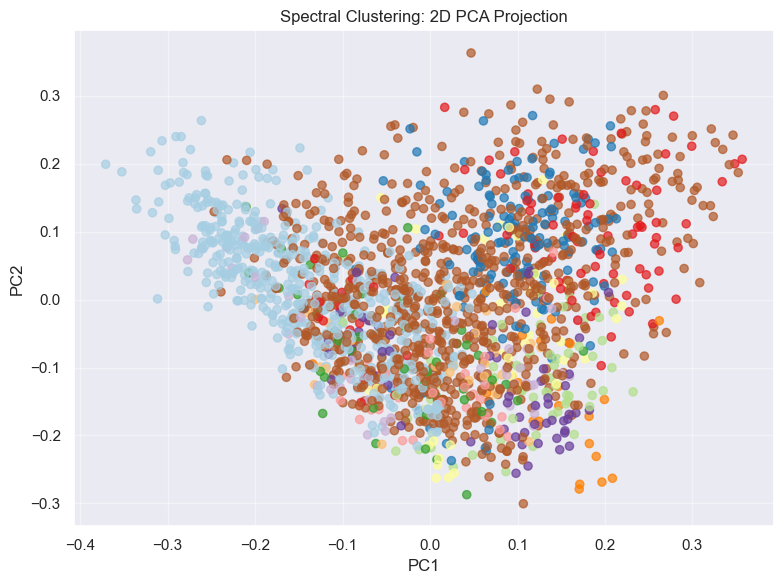

In [163]:
plot_clusters(X_pca_2d, spectral_labels)

### HDBSCAN 

In [14]:
!pip3 install hdbscan

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 8.9 MB/s  0:00:00m0:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.41-cp39-cp39-macosx_10_9_universal2.whl size=1411964 sha256=e274e892c7e909825647e691dc87cf0385e86dba5faf0555bc1c08f6e37a6b4b
  Stored in directory: /Users/viktoriiavlasenko/Library/Caches/pip/wheels/8a/25/ef/ea295bd6ff503043606cbf608f923aaa71b232730dfbef019a
Successfully built hdbscan


In [166]:
from sklearn.neighbors import NearestNeighbors
import hdbscan

In [164]:
def run_hdbscan(X_lsa, min_cluster_size=3, min_samples=None, reassign_noise=True):
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric="euclidean",  # ok here because X_lsa is L2-normalized (cosine-friendly geometry)
        cluster_selection_method="eom",
    )
    labels = clusterer.fit_predict(X_lsa)

    if (-1 in labels) and reassign_noise:
        # Reassign noise to nearest non-noise cluster centroid in X_lsa space
        core_mask = labels != -1
        if core_mask.sum() > 0:
            core_labels = labels[core_mask]
            uniq = np.unique(core_labels)

            centroids = np.vstack([X_lsa[core_mask][core_labels == u].mean(axis=0) for u in uniq])

            nn = NearestNeighbors(n_neighbors=1, metric="euclidean")
            nn.fit(centroids)
            noise_idx = np.where(labels == -1)[0]
            nearest = nn.kneighbors(X_lsa[noise_idx], return_distance=False).ravel()
            labels[noise_idx] = uniq[nearest]

    return labels

In [165]:
def run_hdbscan(X_lsa, min_cluster_size=5, min_samples=3):
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric="euclidean",
        cluster_selection_method="eom"
    )
    labels = clusterer.fit_predict(X_lsa)

    # Map noise (-1) to a single extra cluster
    if -1 in labels:
        labels = labels.copy()
        labels[labels == -1] = labels.max() + 1

    return labels

In [170]:
hdbscan_labels = run_hdbscan(X_lsa)
create_submission(hdbscan_labels)

,ID,TARGET
0,0,63
1,1,56
2,2,63
3,3,52
4,4,63
...,...,...
1929,1929,63
1930,1930,63
1931,1931,1
1932,1932,15


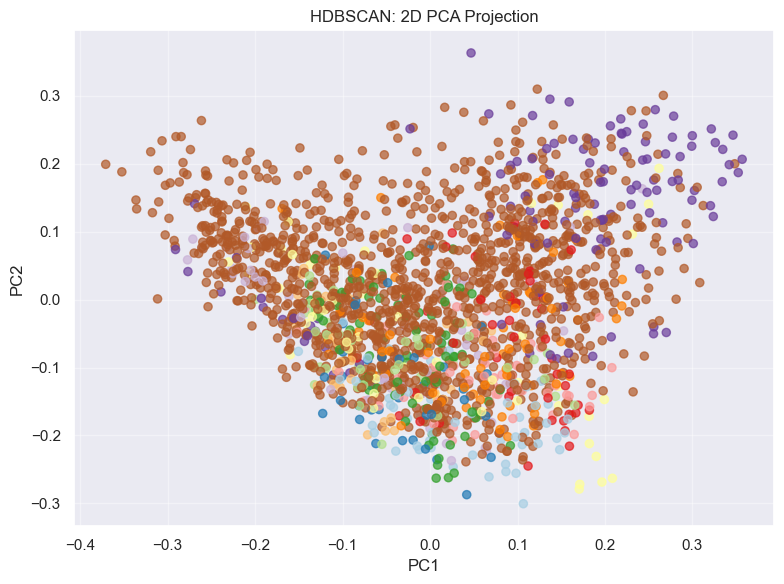

In [171]:
plot_clusters(X_pca_2d, hdbscan_labels, title="HDBSCAN: 2D PCA Projection")

In [172]:
labels, counts = np.unique(hdbscan_labels, return_counts=True)
for l, c in zip(labels, counts):
    print(f"Cluster {l}: {c}")

Cluster 0: 8
Cluster 1: 12
Cluster 2: 8
Cluster 3: 6
Cluster 4: 6
Cluster 5: 15
Cluster 6: 10
Cluster 7: 12
Cluster 8: 5
Cluster 9: 5
Cluster 10: 5
Cluster 11: 5
Cluster 12: 10
Cluster 13: 13
Cluster 14: 6
Cluster 15: 9
Cluster 16: 13
Cluster 17: 11
Cluster 18: 13
Cluster 19: 19
Cluster 20: 23
Cluster 21: 21
Cluster 22: 10
Cluster 23: 5
Cluster 24: 7
Cluster 25: 6
Cluster 26: 9
Cluster 27: 6
Cluster 28: 8
Cluster 29: 6
Cluster 30: 9
Cluster 31: 16
Cluster 32: 9
Cluster 33: 6
Cluster 34: 10
Cluster 35: 9
Cluster 36: 5
Cluster 37: 6
Cluster 38: 15
Cluster 39: 15
Cluster 40: 21
Cluster 41: 10
Cluster 42: 9
Cluster 43: 6
Cluster 44: 12
Cluster 45: 9
Cluster 46: 6
Cluster 47: 17
Cluster 48: 11
Cluster 49: 7
Cluster 50: 10
Cluster 51: 20
Cluster 52: 68
Cluster 53: 6
Cluster 54: 12
Cluster 55: 6
Cluster 56: 18
Cluster 57: 12
Cluster 58: 5
Cluster 59: 10
Cluster 60: 12
Cluster 61: 37
Cluster 62: 11
Cluster 63: 1207


Looks like **Cluster 63** is a noise cluster. Hyperparams tuning may help?

## 4. Evaluation
The objective of this competition is to cluster books according to their underlying genres using exclusively unsupervised methods.

Participants are required to assign each book to a cluster without using any labeled information during training. The quality of the submitted clustering will be evaluated by comparing the predicted cluster assignments with hidden ground-truth genre labels, which are not available to participants.

The evaluation metric used is the Adjusted Rand Index (ARI), as implemented in scikit-learn:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

The Adjusted Rand Index measures the similarity between two clusterings while correcting for chance. A higher ARI indicates a better alignment between the predicted clusters and the true genre structure.

**Kaggle evaluation results (with ARI)**:
|$k$|K-Means++ (description)|K-Means++ (description + 3 reviews)|K-Means++ (all reviews)|Spectral Clustering (description + 3 reviews)|
|---|---|---|---|---|
|22|0.27544|0.53381|0.45601|0.39303|
|23|**0.25870**|0.53381|0.45736|**0.46513**|
|24|0.25278|0.53163|0.45368|0.43356|
|**25**|0.24821|**0.55432**|**0.48028**|0.44850|
|26|0.24150|0.52341|0.44971|0.45329|
|27|0.23754|0.51813|0.44866|0.44490|
|45|0.16602|0.37280|0.28173|0.29480|
|60|0.14566|0.22353|0.26966|0.18596|

We expected much better results using **HDBSCAN** but get only $ARI = 0.02554$.

By results we see that **K-Means++** performs the best over the merged feature of book's description text and 3 reviews (very few to enrich general information for genre clustering) for $k=25$.